In [15]:
import numpy as np
import os
import matplotlib.pyplot as plt
from qutip import *
from matplotlib import gridspec
from tqdm import tqdm
%matplotlib inline

### System parameters definition


In [16]:

N_atoms = 7  # number of atoms in the atom chain
Omega = 2 * np.pi * 3e6  # Rabi frequency of the driving laser (e.g., 3 MHz)
Omega_eff = Omega / np.sqrt(2) # effective Rabi frequency
V_r1 = Omega * 20  # Rydberg-Rydberg interaction strength corresponding to r1
V_r2 = Omega * 10  # Rydberg-Rydberg interaction strength corresponding to r2
print(V_r1, V_r2)
# V_r1_r2 = ... # the paper mentions that it can be ignored under non-uniform spacing, but may be needed in some cases
r1_distance = 11.4e-6 # theoretically r1 and r2 are physical distances (meters)
r2_distance = 12.8e-6

# van der Waals coefficient C6 (needs to be determined according to the atomic type and Rydberg state)
# the paper mentions that C6 scale is n^11, here is just a placeholder
# C6_coefficient = ...

# pulse parameters (according to the optimization result of Figure 2)
delta_Delta1 = -0.133 * Omega # detuning of the first pulse
delta_Delta2 = -0.033 * Omega # detuning of the second pulse
T_pulse_unit = 0.5 * (2 * np.pi) / Omega_eff # time unit defined in the paper \tilde{\Omega}T/(2\pi) = 0.5

# decay and dephasing rates (used in Lindblad master equation, according to Figure 4 in the paper)
Gamma_decay = 0.002 * Omega # decay rate
Gamma_dephasing = 0.004 * Omega # dephasing rate

# --- Quantum state and operator definition ---
# in QuTiP, |0> is usually the ground state, |1> is the Rydberg state
dim = [2] * N_atoms # Hilbert space dimension of N atoms, each atom has 2 states

# define the single-atom operators
sm = destroy(2) # lowering operator |0><1|
sp = create(2)  # raising operator |1><0|
sz = sigmaz()   # Pauli Z operator |1><1| - |0><0|
n_op = sp * sm  # number operator |1><1|

376991118.43077517 188495559.21538758


In [17]:
# define the operators for the multi-atom system
def get_operator(op_single_atom, site_idx, num_atoms):
    """create the operators for the specific atom site in the multi-atom system"""
    op_list = [identity(2)] * num_atoms
    op_list[site_idx] = op_single_atom
    return tensor(op_list)

# --- Pulse Sequence Generation ---
def generate_pulse_sequence(total_time, time_points, mode='periodic', **kwargs):
    """
    Generates the time-dependent laser detuning pulse sequence.
    
    Args:
        total_time (float): Total simulation time.
        time_points (int): Number of time points for the sequence.
        mode (str): 'periodic' for alternating pulses, 'custom' for a user-defined sequence.
        **kwargs:
            For 'periodic' mode:
                Delta1_val (float): Detuning value for the first pulse type.
                Delta2_val (float): Detuning value for the second pulse type.
                T_pulse_unit (float): Duration of a single pulse unit.
                delta_Delta1 (float): Small detuning mismatch for Delta1_val.
                delta_Delta2 (float): Small detuning mismatch for Delta2_val.
            For 'custom' mode:
                custom_sequence (list): A list of tuples (start_time, end_time, detuning_value).
                                        Times should be absolute.
    Returns:
        tuple: (times (np.array), pulse_detunings (np.array))
    """
    times = np.linspace(0, total_time, time_points)
    pulse_detunings = np.zeros_like(times)

    if mode == 'periodic':
        Delta1_val = kwargs.get('Delta1_val')
        Delta2_val = kwargs.get('Delta2_val')
        T_pulse_unit = kwargs.get('T_pulse_unit')
        delta_Delta1 = kwargs.get('delta_Delta1', 0)
        delta_Delta2 = kwargs.get('delta_Delta2', 0)

        if None in [Delta1_val, Delta2_val, T_pulse_unit]:
            raise ValueError("For 'periodic' mode, Delta1_val, Delta2_val, T_pulse_unit must be provided.")

        for i, t in enumerate(times):
            l = int(t / (2 * T_pulse_unit))
            if (2*l)*T_pulse_unit <= t < (2*l+1)*T_pulse_unit:
                pulse_detunings[i] = Delta1_val + delta_Delta1
            elif (2*l+1)*T_pulse_unit <= t < (2*l+2)*T_pulse_unit:
                pulse_detunings[i] = Delta2_val + delta_Delta2
    elif mode == 'custom':
        custom_sequence = kwargs.get('custom_sequence')
        if not isinstance(custom_sequence, list):
            raise ValueError("For 'custom' mode, 'custom_sequence' (list of tuples) must be provided.")
        
        for start_t, end_t, detuning_val in custom_sequence:
            # Find indices within the current custom pulse interval
            indices = np.where((times >= start_t) & (times < end_t))
            pulse_detunings[indices] = detuning_val
    else:
        raise ValueError(f"Unknown pulse generation mode: {mode}. Use 'periodic' or 'custom'.")

    return times, pulse_detunings

# --- Hamiltonian construction ---
# Modified to receive current_Delta directly
def build_hamiltonian(current_Delta, N, Omega_val, V_r1_val, V_r2_val):
    """
    Build the Hamiltonian H(t) for the given current detuning.
    This is the most core part of the paper, requiring precise construction
    based on interatomic distances and interactions.
    """
    H = 0

    # Rabi coupling term: Omega/2 * sum(e^(-iDelta*t) * sigma_j_plus + H.c.)
    # For QuTiP's time-dependent H, this part needs to be carefully handled.
    # We will define the full time-dependent Hamiltonian for QuTiP using `Qobj` with `qfunc`.
    # For `build_hamiltonian` to return a static Qobj for `H_time_independent_parts`,
    # we'll create the detuning part separately in `simulate_dynamics`.

    # Interaction terms: V_r1, V_r2, V_r1+r2 (simplified to nearest neighbors only)
    # Distance r1 (odd-even pairs)
    for j in range(0, N - 1, 2): # 1-2, 3-4, ... (0-indexed)
        n_j = get_operator(n_op, j, N)
        n_j_plus_1 = get_operator(n_op, j + 1, N)
        H += V_r1_val * n_j * n_j_plus_1

    # Distance r2 (even-odd pairs)
    for j in range(1, N - 1, 2): # 2-3, 4-5, ... (0-indexed)
        n_j = get_operator(n_op, j, N)
        n_j_plus_1 = get_operator(n_op, j + 1, N)
        H += V_r2_val * n_j * n_j_plus_1

    # The detuning term will be added as a time-dependent coefficient in simulate_dynamics
    # It's proportional to `sum_j(n_j) * Delta(t)` or related to the driving field.
    # The paper's H(t) has Delta_i * t in the exponential, suggesting a rotating frame.
    # Here, we represent the detuning directly on the Rydberg states.
    for j in range(N):
        H += -current_Delta * get_operator(n_op, j, N) # Simplified detuning term

    # Rabi term (time-independent for the base component in a rotating frame)
    H_rabi = 0
    for j in range(N):
        H_rabi += Omega_val / 2 * (get_operator(sp, j, N) + get_operator(sm, j, N))

    return H + H_rabi # Return combined Hamiltonian for a specific detuning

# Define the collapse operators (Lindblad master equation)
def get_collapse_operators(N, Gamma_decay_val, Gamma_dephasing_val):
    """
    Build the collapse operators in the Lindblad master equation
    """
    c_ops = []
    # Decay term L_decay(rho)
    for k in range(N):
        c_ops.append(np.sqrt(Gamma_decay_val) * get_operator(sm, k, N))

    # Dephasing term L_deph(rho)
    for k in range(N):
        c_ops.append(np.sqrt(Gamma_dephasing_val) * get_operator(sz, k, N))
    return c_ops

# Simulate the dynamics of the system
def simulate_dynamics(initial_state, total_time, time_points,
                      N_atoms, Omega_val, V_r1_val, V_r2_val,
                      pulse_times, pulse_detunings, # Pass pre-generated pulse
                      Gamma_decay_val=0, Gamma_dephasing_val=0, use_lindblad=False):
    """
    Simulate the quantum dynamics of the system
    initial_state: initial quantum state (QuTiP Qobj)
    total_time: total simulation time
    time_steps: number of time steps
    """
    times = np.linspace(0, total_time, time_points)

    # Define the time-dependent Hamiltonian as a QuTiP Qobj object, and use the parameterized function
    H_func = lambda t, args: build_hamiltonian(
        np.interp(t, pulse_times, pulse_detunings), # Current Delta based on pulse sequence
        args['N'], args['Omega'], args['V_r1'], args['V_r2']
    )
    args = {'N': N_atoms, 'Omega': Omega_val, 'V_r1': V_r1_val, 'V_r2': V_r2_val}

    collapse_operators = get_collapse_operators(N_atoms, Gamma_decay_val, Gamma_dephasing_val)

    if use_lindblad:
        result = mesolve(H_func, initial_state, times, c_ops=collapse_operators, args=args, options={'progress_bar': 'tqdm'})
    else:
        result = sesolve(H_func, initial_state, times, args=args, options={'progress_bar': 'tqdm'})

    return result.states # or result.expect for expectation values

# Helper function: calculate the Rydberg population
def calculate_rydberg_population(states, N_atoms):
    """
    Extract the Rydberg population for each atom from the simulation results
    states: list of quantum states returned from the simulation (QuTiP Qobj list)
    """
    populations = np.zeros((len(states), N_atoms))
    n_op_list = [get_operator(n_op, i, N_atoms) for i in range(N_atoms)]
    for i, state in enumerate(states):
        for j in range(N_atoms):
            populations[i, j] = expect(n_op_list[j], state)
    return populations 

# Helper function: calculate the fidelity of the Bell state
def calculate_bell_state_fidelity(final_density_matrix, atom1_idx, atom2_idx):
    """
    Calculate the fidelity of the Bell state (Figure 4b)
    final_density_matrix: final density matrix (QuTiP Qobj)
    atom1_idx, atom2_idx: indices of the two atoms in the Bell pair
    """
    target_bell_state = (tensor(basis(2,0), basis(2,1)) + tensor(basis(2,1), basis(2,0))).unit() / np.sqrt(2)
    rho_reduced = final_density_matrix.ptrace([atom1_idx, atom2_idx]) # trace out the irrelevant atoms
    fid = fidelity(rho_reduced, target_bell_state)
    return fid


## 1. Single excitation transmission simulation (similar to Figure 2a)


In [18]:
initial_atom_idx = 0  # Initial excitation on the first atom (0-indexed)
# Initialize the single excitation state: |00...010...0> where 1 is at initial_atom_idx
initial_state_single = tensor(
        [basis(2,0)] * initial_atom_idx + [basis(2,1)] + [basis(2,0)] * (N_atoms - initial_atom_idx - 1)
        ) 
    
total_sim_time = 5 * T_pulse_unit * 2 # Simulate 5 periods of transmission (2l)T to (2l+2)T corresponds to a complete period.
time_points = 200 # Number of time steps

### Example 1: Periodic Pulse Sequence


100%|██████████| 199/199 [00:06<00:00, 29.35it/s]


  Truth-table transport fidelity F6 (Periodic): 0.078


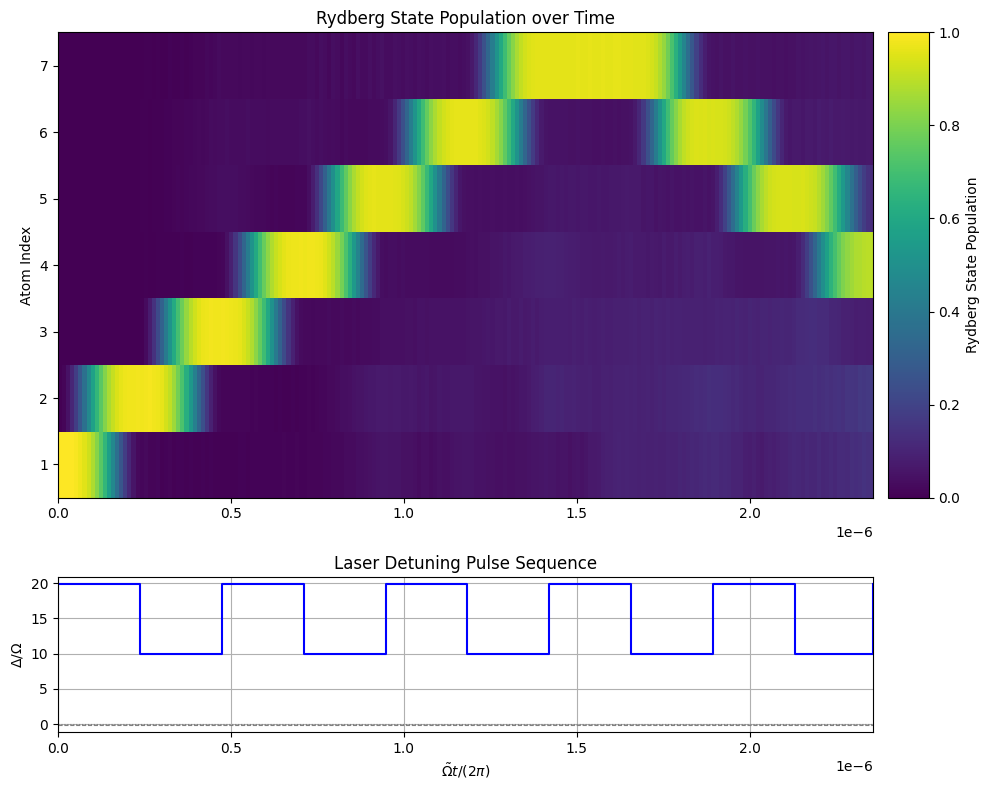

In [19]:
times_periodic_sim, pulse_detunings_periodic_sim = generate_pulse_sequence(
        total_sim_time, time_points, mode='periodic',
        Delta1_val=V_r1, Delta2_val=V_r2, T_pulse_unit=T_pulse_unit,
        delta_Delta1=delta_Delta1, delta_Delta2=delta_Delta2
    )

states_single_excitation_periodic = simulate_dynamics(
        initial_state_single, total_sim_time, time_points, N_atoms,
        Omega, V_r1, V_r2, # Interaction strengths
        times_periodic_sim, pulse_detunings_periodic_sim, # Pass pre-generated pulse
        Gamma_decay_val=0, Gamma_dephasing_val=0, use_lindblad=False
    )

rydberg_populations_periodic = calculate_rydberg_population(
        states_single_excitation_periodic, N_atoms 
    )

final_state_periodic = states_single_excitation_periodic[-1]
target_state_F6 = tensor(
        [basis(2,0)] * 5 + [basis(2,1)] + [basis(2,0)] * (N_atoms - 1 - 5)
    )
fidelity_F6_periodic = fidelity(final_state_periodic, target_state_F6)
print(f"  Truth-table transport fidelity F6 (Periodic): {fidelity_F6_periodic:.3f}")

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], width_ratios=[20, 1]) # for colorbar
    
ax1 = fig.add_subplot(gs[0, 0]) # main plot (population)
ax_cb = fig.add_subplot(gs[0, 1]) # colorbar axis
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1) # pulse sequence plot, share the x-axis with ax1

# plot the Rydberg state population
im = ax1.imshow(rydberg_populations_periodic.T, extent=[times_periodic_sim[0], times_periodic_sim[-1], 0.5, N_atoms + 0.5],
                aspect='auto', origin='lower', cmap='viridis', vmin=0, vmax=1)
fig.colorbar(im, cax=ax_cb, label='Rydberg State Population')
ax1.set_ylabel('Atom Index')
ax1.set_yticks(np.arange(1, N_atoms + 1))
ax1.set_title('Rydberg State Population over Time')
ax1.grid(False)
    
# convert to \Omega t / (2\pi) format, and the Delta values also need to be adjusted, so that the figure is consistent with the paper
# in the paper, Delta is relative to V_r, here we directly plot the Delta values
ax2.plot(times_periodic_sim, pulse_detunings_periodic_sim / Omega, color='blue', drawstyle='steps-post')
ax2.set_xlabel(r'$\tilde{\Omega} t / (2\pi)$')
ax2.set_ylabel(r'$\Delta / \Omega$')
ax2.set_title('Laser Detuning Pulse Sequence')
ax2.grid(True)
ax2.axhline(delta_Delta1 / Omega, color='gray', linestyle='--', linewidth=0.8)
ax2.axhline(delta_Delta2 / Omega, color='gray', linestyle=':', linewidth=0.8)

plt.tight_layout()
plt.show()

### Example 2: Custom Pulse Sequence


100%|██████████| 199/199 [00:08<00:00, 24.36it/s]

  Truth-table transport fidelity F6 (Custom): 0.074


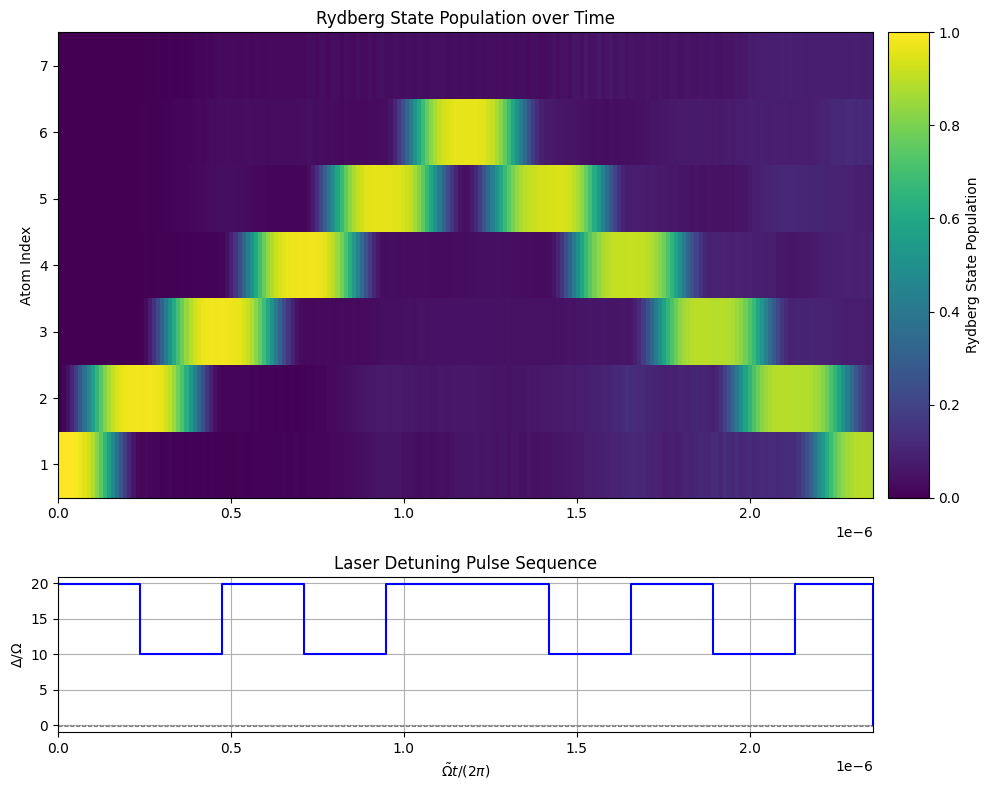

In [20]:
# Example custom sequence: A square pulse of Delta1, then Delta2, then back to Delta1
custom_pulse_def = [
        (0, T_pulse_unit, V_r1 + delta_Delta1),
        (T_pulse_unit, 2 * T_pulse_unit, V_r2 + delta_Delta2),
        (2 * T_pulse_unit, 3 * T_pulse_unit, V_r1 + delta_Delta1),
        (3 * T_pulse_unit, 4 * T_pulse_unit, V_r2 + delta_Delta2),
        (4 * T_pulse_unit, 6 * T_pulse_unit, V_r1 + delta_Delta1),
        (6 * T_pulse_unit, 7 * T_pulse_unit, V_r2 + delta_Delta2),
        (7 * T_pulse_unit, 8 * T_pulse_unit, V_r1 + delta_Delta1),
        (8 * T_pulse_unit, 9 * T_pulse_unit, V_r2 + delta_Delta2),
        (9 * T_pulse_unit, 10 * T_pulse_unit, V_r1 + delta_Delta1)
    ]
times_custom_sim, pulse_detunings_custom_sim = generate_pulse_sequence(
        total_sim_time, time_points, mode='custom', custom_sequence=custom_pulse_def
    )

states_single_excitation_custom = simulate_dynamics(
        initial_state_single, total_sim_time, time_points, N_atoms,
        Omega, V_r1, V_r2, # Interaction strengths
        times_custom_sim, pulse_detunings_custom_sim, # Pass pre-generated pulse
        Gamma_decay_val=0, Gamma_dephasing_val=0, use_lindblad=False
    )

rydberg_populations_custom = calculate_rydberg_population(
        states_single_excitation_custom, N_atoms 
    )

final_state_custom = states_single_excitation_custom[-1]
fidelity_F6_custom = fidelity(final_state_custom, target_state_F6)
print(f"  Truth-table transport fidelity F6 (Custom): {fidelity_F6_custom:.3f}")


fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], width_ratios=[20, 1]) # for colorbar
    
ax1 = fig.add_subplot(gs[0, 0]) # main plot (population)
ax_cb = fig.add_subplot(gs[0, 1]) # colorbar axis
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1) # pulse sequence plot, share the x-axis with ax1

# plot the Rydberg state population
im = ax1.imshow(rydberg_populations_custom.T, extent=[times_custom_sim[0], times_custom_sim[-1], 0.5, N_atoms + 0.5],
                aspect='auto', origin='lower', cmap='viridis', vmin=0, vmax=1)
fig.colorbar(im, cax=ax_cb, label='Rydberg State Population')
ax1.set_ylabel('Atom Index')
ax1.set_yticks(np.arange(1, N_atoms + 1))
ax1.set_title('Rydberg State Population over Time')
ax1.grid(False)

    
# convert to \Omega t / (2\pi) format, and the Delta values also need to be adjusted, so that the figure is consistent with the paper
# in the paper, Delta is relative to V_r, here we directly plot the Delta values
ax2.plot(times_custom_sim, pulse_detunings_custom_sim / Omega, color='blue', drawstyle='steps-post')
ax2.set_xlabel(r'$\tilde{\Omega} t / (2\pi)$')
ax2.set_ylabel(r'$\Delta / \Omega$')
ax2.set_title('Laser Detuning Pulse Sequence')
ax2.grid(True)
ax2.axhline(delta_Delta1 / Omega, color='gray', linestyle='--', linewidth=0.8)
ax2.axhline(delta_Delta2 / Omega, color='gray', linestyle=':', linewidth=0.8)

plt.tight_layout()
plt.show()

## 2. Bell pair transmission simulation (similar to Figure 4a)


In [21]:
# initial Bell state: for example, between atom 4 and 5
initial_bell_state_idx1 = 3 # atom 4
initial_bell_state_idx2 = 4 # atom 5
initial_bell_state_vec = (
        tensor(
            [basis(2,0)]*initial_bell_state_idx1 + [basis(2,1)] +
            [basis(2,0)]*(initial_bell_state_idx2 - initial_bell_state_idx1 -1) +
            [basis(2,0)] + # This is actually |0> for the second atom, should be |1>
            [basis(2,0)]*(N_atoms-initial_bell_state_idx2-1)
        ) +
        tensor(
            [basis(2,0)]*initial_bell_state_idx1 + [basis(2,0)] +
            [basis(2,0)]*(initial_bell_state_idx2 - initial_bell_state_idx1 -1) +
            [basis(2,1)] + # This is actually |1> for the second atom
            [basis(2,0)]*(N_atoms-initial_bell_state_idx2-1)
        )).unit() # This is a basic Bell state, needs to be more specific to paper
initial_bell_state_rho = ket2dm(initial_bell_state_vec) # density matrix

total_sim_time_bell = 3 * T_pulse_unit * 2 # simulate 3 pulse periods
time_points_bell = 150

# run simulation (with decay and dephasing)
states_bell_pair = simulate_dynamics(
        initial_bell_state_rho, total_sim_time_bell, time_points_bell, N_atoms,
        Omega, V_r1, V_r2, V_r1, V_r2,
        Gamma_decay_val=Gamma_decay, Gamma_dephasing_val=Gamma_dephasing, use_lindblad=True
    )

# calculate the Bell state fidelity at each time step
fidelities_bell = []
for state in states_bell_pair:
    fid = calculate_bell_state_fidelity(state, 0, N_atoms - 1)
    fidelities_bell.append(fid)

plt.figure(figsize=(12, 7))
plt.plot(range(1, len(fidelities_bell) + 1), fidelities_bell, marker='o', linestyle='-')
plt.xlabel('Step')
plt.ylabel('Fidelity')
plt.title('Bell State Fidelity over Time')
plt.ylim(0, 1)
plt.grid(True)
plt.show()



ValueError: object of too small depth for desired array